# 결정트리, 랜덤 포레스트, 부스팅
- 결정트리를 이용한 분류 모델 만들기
- 분류 모델의 손실함수
- 분류의 성능 평가
- 특성 중요도 (feature_importances_)
- 랜덤포레스트 이해
- 부스팅 알고리즘 이해
- 타이타닉 분류 문제

# import

In [1]:
## 기본 환경설정

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

# 맥에서 레티나 디스플레이 사용 설정
%config InlineBackend.figure_format = 'retina'

# 그림 크기와 폰트 설정
matplotlib.rcParams['figure.figsize'] = (6,4)
plt.rc('font', size=13)

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import  SGDClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn import tree
from sklearn.metrics import confusion_matrix,classification_report

# 데이터
## 타이타닉 생존 여부 예측

- Survival - 생존여부(타겟변수 y): 0 = No, 1 = Yes
- Pclass - 티켓 등급: 1 = 1st, 2 = 2nd, 3 = 3rd
- Sex - 성별: male, female
- Age - 나이
- SibSp - 동승한 형제, 배우자 수
- Parch - 부모와 자녀의 수
- Ticket - 티켓 번호
- Fare - 승선 요금
- Cabin - 캐빈(객실) 번호
- Embarked - 승선한 항구: C = Cherbourg, Q = Queenstown, S = Southampton

## 데이터 전처리 종류

- 데이터 클리닝 - 결측치 처리, 틀린값 처리
- 스케일링 - 여러 변수 값의 범위를 동등한 조건으로 맞추는 것: 표준 스케일링, min-max 스케일링
- 이상치 처리 - 이상치 탐지 및 제거
- 데이터 변환 - 로그 변환, 카테고리 인코딩 등

In [3]:
## 데이터 전처리

# 데이터 다운로드하기
df = pd.read_csv("https://raw.githubusercontent.com/StillWork/data/master/titanic_train.csv")

# 나이 결측치를 평균 나이로 대체 (대체한 것을 즉시 반영했다)
df.Age.fillna(df.Age.mean(), inplace=True)

# Embarked (항구명) 결측치가 있는 두 샘플은 삭제한다
df = df[~df["Embarked"].isnull()]

# 사용하지 않을 컬럼 4개를 삭제한다
df = df[df.columns.difference(['PassengerId','Name','Ticket','Cabin'])]

# 선실등급, 성별, 항구명을 원핫 인코딩한다
df = pd.get_dummies(df, columns=['Pclass','Sex','Embarked'])

# 요금(Fare)은 로그를 취한 값을 사용한다
df["Fare"] = np.log(df.Fare +1)

# 트리 모델은 스케일링을 하지 않아도 된다!
# 연속형 변수에 표준 스케일링을 적용한다
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# df.loc[:][['Age','Fare','SibSp','Parch']] = scaler.fit_transform(df[['Age','Fare','SibSp','Parch']])

# X와 y 얻기
X = df[df.columns.difference(['Survived'])]
y = df.Survived

# X, y 크기 확인하기
print(X.shape, y.shape)

(889, 12) (889,)


# 선형 모델 분류

In [4]:
## 데이터 나누기

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)

In [5]:
## 선형 분류 모델로 SGDClassifier를 사용
lin = SGDClassifier()

# 학습 데이터를 사용하여 학습을 수행한다
lin.fit(X_train, y_train)

# 검증 데이터를 사용하여 모델의 성능을 확인한다 (디폴트로 정확도를 알려준다)
lin.score(X_test, y_test)

0.7892376681614349

In [6]:
## 선형 모델 가중치
lin.coef_[0]

array([ -2.07661274,   8.46484068,  20.15438257,  -8.26329685,
        43.92583494, -18.74357579,  48.57206199,  16.52659371,
       -44.74272931, 103.59352641, -83.23760002, -27.4099603 ])

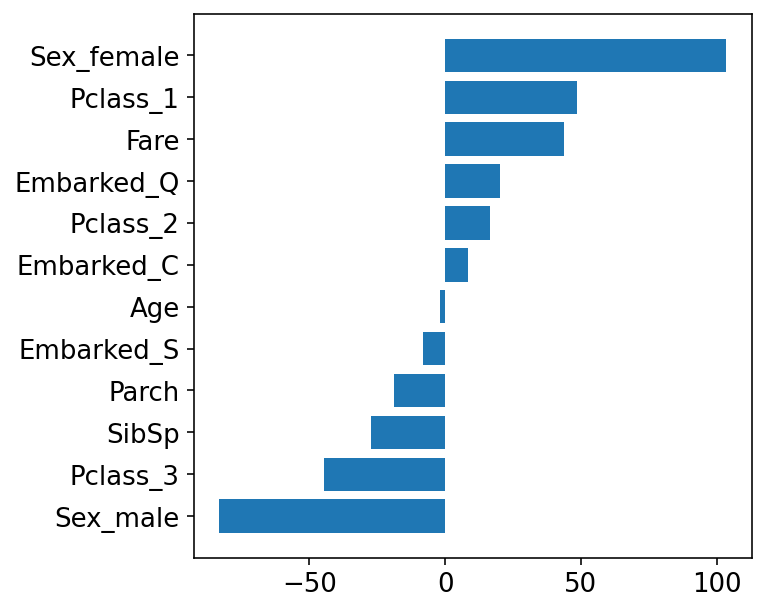

In [7]:
## 선형 모델 가중치 보기

def plot_feature_weight(feature, weight):
    plt.figure(figsize=(5,5))
    W = pd.DataFrame({'feature':feature,'weight':weight})
    W.sort_values('weight', inplace=True)
    plt.barh(W.feature, W.weight)

plot_feature_weight(X.columns, lin.coef_[0])

- 위 결과를 보면 생존하는데 가장 많이 기여한 변수는 여성, 요금, 1등석 등이고
- 생존하지 않는데 가장 많이 기여한 변수는 남성, 나이, 3등객실 등인 것을 알 수 있다

# 결정트리 모델 분류

- 동작 개요

<img src = "https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202023-05-07%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2011.17.21.png?raw=1" width="250"  align="left">




## 트리를 만드는 과정


<img src = "https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202023-05-07%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2010.53.59.png?raw=1" width="600"  align="left">
<img src = "https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202023-05-07%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2010.54.34.png?raw=1" width="600"  align="left">




## 트리 모델 과대적합

- 트리 모델은 depth를 크게 하면 항상 과대적합이 된다

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202023-05-07%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%2010.55.04.png?raw=1" width="600"  align="left">




## 트리모델의 손실함수

- 각 depth에서 결정 트리를 선택하는 기준은 새로 나누어질 그룹에 가능하면 같은 종류의 샘플이 많이 나누어 모이는 지를 측정한다
- 즉, 순도(purity)가 가능한 높아지도록 나눈다
- 순도가 높아지는 것을 측정하는데 엔트로피를 사용한다
 - 순도가 높아질수록 엔트로피는 줄어든다

### 엔트로피 

- 확률 p인 사건의 가치:  $log$(${1}\over{p}$) 
- 엔트로피=확률x기대치: $Entropy(H)$ = $p$ $log$(${1}\over{p}$)

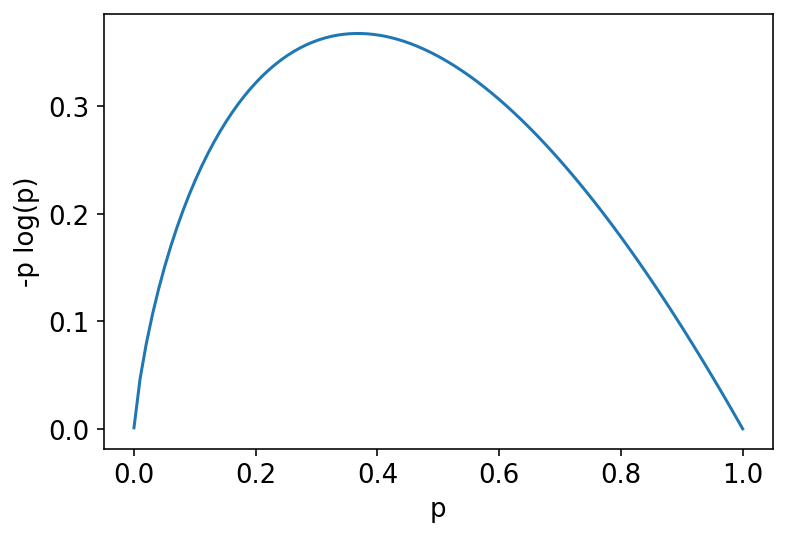

In [8]:
## 확률 p와 엔트로피 보기

xs = np.linspace(0.0001, 1, 100)
plt.plot(xs, -xs*np.log(xs))
plt.xlabel("p")
plt.ylabel("-p log(p)")
plt.show()

### 크로스 엔트로피 

- 분류할 여러 클래스들에 대해서 각각의 엔트로피를 더한 값을 크로스 엔트로피라고 한다
- 분류가 잘 수행될수록 (즉, 분류된 하위 그룹의 p가 1 또는 0으로 수렴할수록) 크로스 엔트로피의 합은 점차 줄어들며 이를 분류의 손실함수로 사용한다

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%8C%E1%85%A5%E1%86%AB%208.29.58.png?raw=1" align='left'  width=150>

### gini 계수 도입

- 크로스 엔트로피와 유사한 값을 얻으면서 계산량을 줄이기 위해서 지니 계수를 주로 사용한다

$1 - \sum {p_{i}}^2$

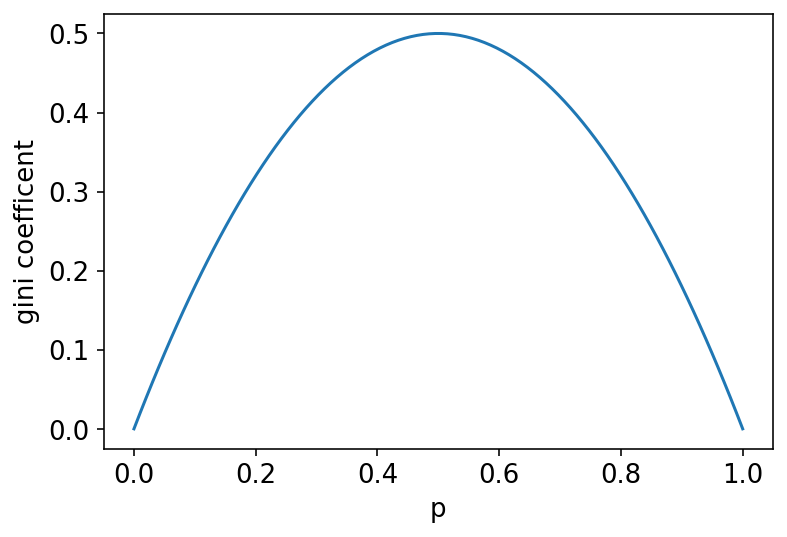

In [9]:
## 이진 분류에 대해서, 확률 p와 (1-p)의 지니 계수 보기

xs = np.linspace(0, 1, 100)
plt.plot(xs, 1-(xs**2 + (1-xs)**2))
plt.xlabel("p")
plt.ylabel("gini coefficent")
plt.show()

In [10]:
# 샘플을 a와 b개로 나누었을 때 지니 계수를 구하는 함수
def gini_index(a,b):
    p = a/(a+b)
    q = 1 - p
    return np.round((1-p**2 - q**2),3)

In [11]:
# 타이타닉 훈련 데이터 666 샘플 y 값의 분포

y.value_counts()

0    549
1    340
Name: Survived, dtype: int64

In [12]:
# 분류하기 전에 (root trre) 타이타닉 훈련의 지니계수
gini_index(409,257)

0.474

# 결정 트리를 이용한 이진 분류

In [13]:
## 결정 트리를 이용한 이진 분류

# 최적의 트리 깊이 (max_depth)를 찾는다
for depth in range(1,10):
    dtc = DecisionTreeClassifier(max_depth=depth) 
    dtc.fit(X_train, y_train) 
    print(depth, dtc.score(X_test, y_test).round(3)) 

1 0.794
2 0.762
3 0.812
4 0.812
5 0.803
6 0.776
7 0.726
8 0.726
9 0.744


0.812


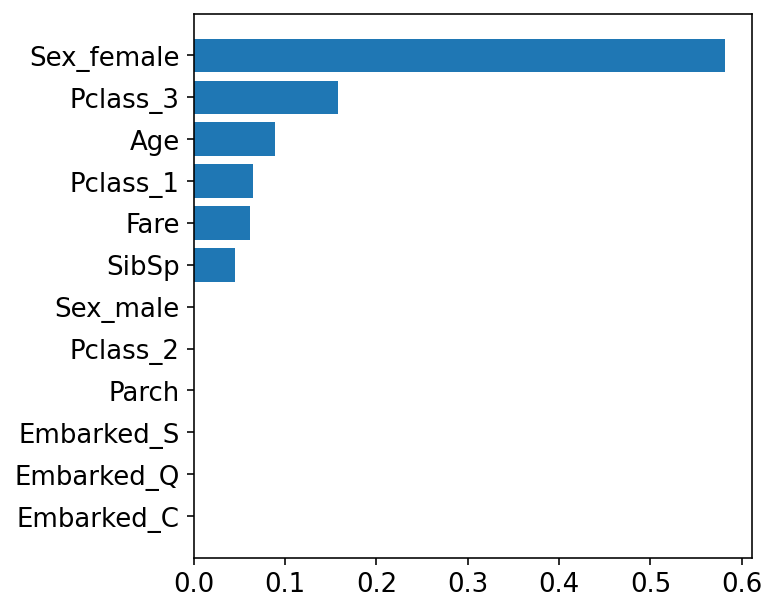

In [14]:
## 최적의 트리 깊이 max_depth=3

dtc = DecisionTreeClassifier(max_depth=3) 
dtc.fit(X_train, y_train) 
print(dtc.score(X_test, y_test).round(3)) 

plot_feature_weight(X.columns, dtc.feature_importances_)

## 혼돈 매트릭스와 분류 평가 보기

In [15]:

def show_clf_result(y_test, y_pred):
    print(confusion_matrix(y_test, y_pred))
    print(classification_report(y_test, y_pred))

y_pred = dtc.predict(X_test)
show_clf_result(y_test, y_pred)

[[120  20]
 [ 22  61]]
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       140
           1       0.75      0.73      0.74        83

    accuracy                           0.81       223
   macro avg       0.80      0.80      0.80       223
weighted avg       0.81      0.81      0.81       223



In [16]:
## 검증 데이터의 사망(0) 및 생존(1) 확률 보기
dtc.predict_proba(X_test)[:5].round(3)

array([[0.621, 0.379],
       [0.892, 0.108],
       [0.04 , 0.96 ],
       [0.892, 0.108],
       [0.04 , 0.96 ]])

In [17]:
## 검증 데이터의 생존 확률 보기

X_test_proba = X_test.copy()
X_test_proba['proba'] = dtc.predict_proba(X_test)[:,1].round(3)
X_test_proba[:5]

,Age,Embarked_C,Embarked_Q,Embarked_S,Fare,Parch,Pclass_1,Pclass_2,Pclass_3,Sex_female,Sex_male,SibSp,proba
35,42.000000,0,0,1,3.970292,0,1,0,0,0,1,1,0.379
563,29.699118,0,0,1,2.202765,0,0,0,1,0,1,0,0.108
496,54.000000,1,0,0,4.372818,0,1,0,0,1,0,1,0.960
371,18.000000,0,0,1,2.014343,0,0,0,1,0,1,1,0.108
306,29.699118,1,0,0,4.717456,0,1,0,0,1,0,0,0.960


## 결정 트리 보기

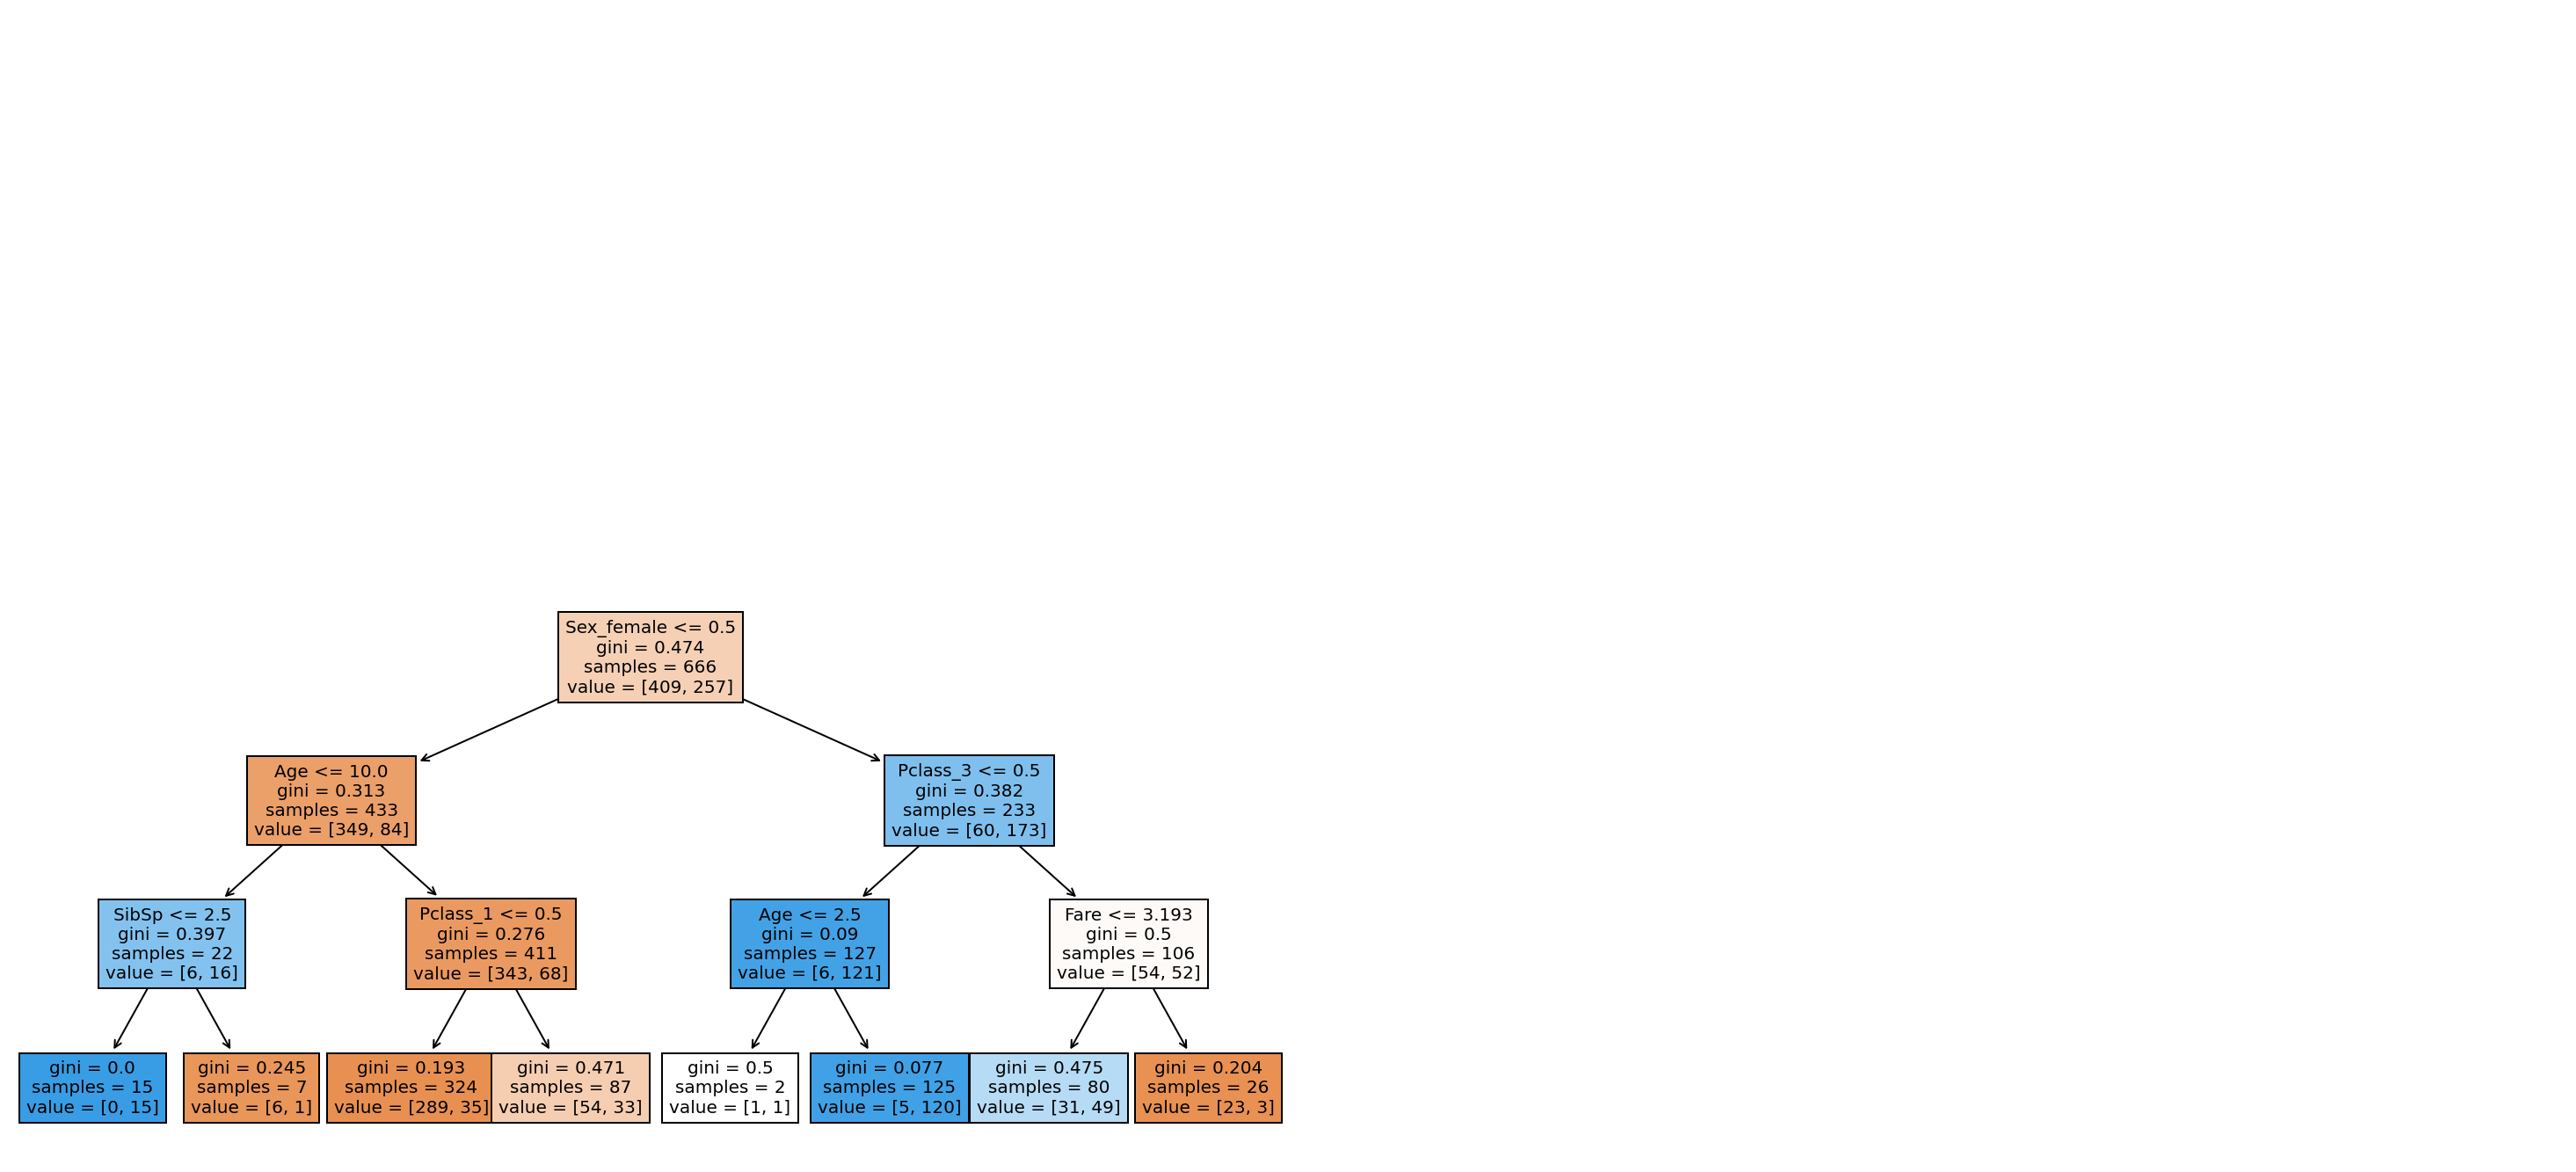

In [18]:
## 결정 트리 보기 (2단까지만 보기)

from sklearn import tree
import matplotlib
plt.figure(figsize=(26,12))

tree.plot_tree(dtc, fontsize=10,
              feature_names=X.columns,
              filled=True,
              impurity=True,
              max_depth=3)
plt.show()

# 랜덤 포레스트

- 결정 트리의 성능을 개선한 방법
- 간단한 구조의 결정 트리(weak learner)를 수십~수백개를 만들고 각 결정 트리의 동작 결과의 평균치를 구하는 방법
- 각 약한 결정 트리를 만들 때 훈련 데이터의 일부만 사용하거나 특성의 일부를 무작위로 선택하여 만든다 
- 이러한 기법을 앙상블(ensemble) 기법이라고 하며, 하나의 디테일한 모델만 만드는 것보다 항상 더 좋은 성능을 보인다
- 앙상블을 구할때 hard voting 또는 soft voting을 선택할 수 있다

- 랜덤 포레스트 개념

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.13.52.png?raw=1" align='left'  width=400>

- 소프트 투표

<img src="https://github.com/StillWork/image/blob/main/%E1%84%89%E1%85%B3%E1%84%8F%E1%85%B3%E1%84%85%E1%85%B5%E1%86%AB%E1%84%89%E1%85%A3%E1%86%BA%202021-03-14%20%E1%84%8B%E1%85%A9%E1%84%92%E1%85%AE%204.52.18.png?raw=1" align='left'  width=400>

In [19]:
## 랜덤 포레스트를 이용한 이진 분류

# 최적의 트리 깊이(max_depth)를 실험으로 찾는다
# 약한 트리 모델 갯수, n_estimators 디폴트 값은 100이다

for depth in range(1,10):
    rfc = RandomForestClassifier(n_estimators = 50, max_depth=depth)
    rfc.fit(X_train, y_train) 
    print(depth,rfc.score(X_test, y_test).round(4))

1 0.7937
2 0.7937
3 0.7982
4 0.8251
5 0.8206
6 0.8072
7 0.8027
8 0.7982
9 0.7937


In [20]:
## 최적의 모델 (max_depth=5)

rfc = RandomForestClassifier(max_depth=5)
rfc.fit(X_train, y_train) 
print(rfc.score(X_test, y_test).round(4))

# 혼돈 매트릭스와 분류 평가 보기
y_pred = rfc.predict(X_test)
show_clf_result(y_test, y_pred)

0.8117
[[124  16]
 [ 26  57]]
              precision    recall  f1-score   support

           0       0.83      0.89      0.86       140
           1       0.78      0.69      0.73        83

    accuracy                           0.81       223
   macro avg       0.80      0.79      0.79       223
weighted avg       0.81      0.81      0.81       223



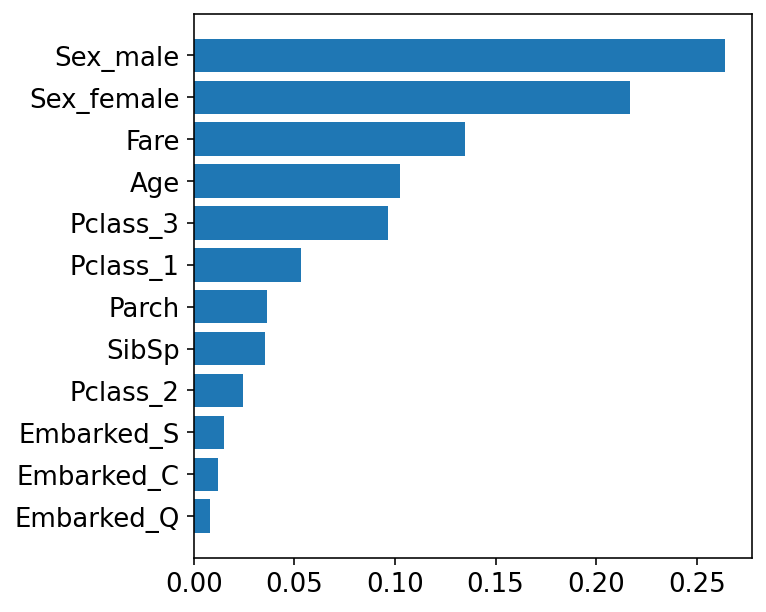

In [21]:
## 특성 중요도 (feature_importances_ 보기)

plot_feature_weight(X.columns, rfc.feature_importances_)

# 부스팅 (LightGBM)

- 랜덤 포레스트가 다수의  weak 트리모델을 병행하여 실행하고 결과를 취한하는 방식이라면, 부스팅 모델은 다수의 트리 모델을 순차적으로 실행하는 방식이다
- 순차적으로 실행하면서 앞 단의 모델 결과를 반영하여 점차 성능을 개선하는 방햑으로 하습시킨다(boosting)
- lightgbm을 설치해야 한다
 - !conda install lightgbm -y

In [22]:
## 최적의 모델 찾기 (max_depth)

for depth in range(1,10):
    lgbm_c = LGBMClassifier(max_depth=depth,num_leaves=64)
    lgbm_c.fit(X_train, y_train)
    print(depth, lgbm_c.score(X_test, y_test).round(4))

1 0.8117
2 0.8161
3 0.8027
4 0.8206
5 0.8206
6 0.8161
7 0.7982
8 0.7892
9 0.8117


In [23]:
## 최적의 모델 (max_depth=4)

lgbm_c = LGBMClassifier(max_depth=4)
lgbm_c.fit(X_train, y_train)
lgbm_c.score(X_test, y_test)

0.820627802690583

In [24]:
## 혼돈 매트릭스와 분류 평가 보기

y_pred = lgbm_c.predict(X_test)
show_clf_result(y_test, y_pred)

[[122  18]
 [ 22  61]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       140
           1       0.77      0.73      0.75        83

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



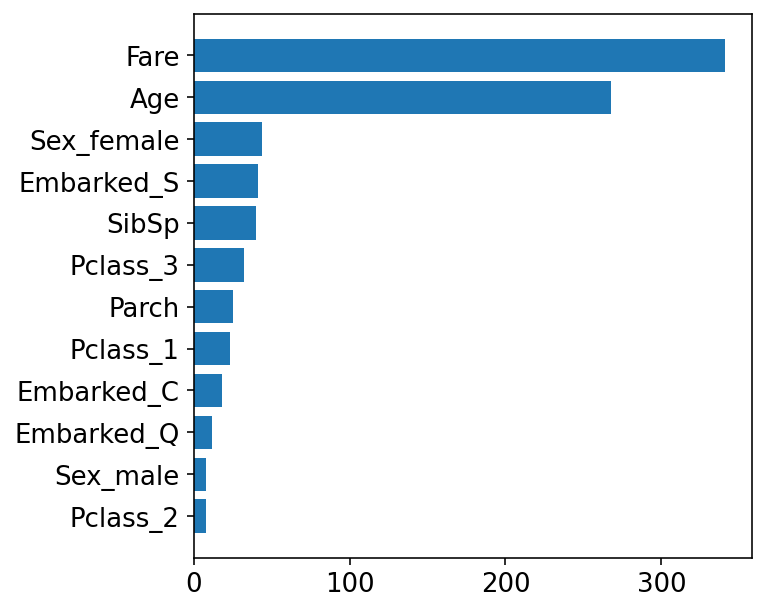

In [25]:
## 특성 중요도 (feature_importances_ 보기)

plot_feature_weight(X.columns, lgbm_c.feature_importances_)

# 정밀도와 재현률 선택
- 클래스 분류 확률을 이용하여 정밀도가 높거나, 재현률이 높은 예측 모델을 만들 수 있다 

In [26]:
# 클래스 분류 확률 (1이라고 분류할 확률)

proba = lgbm_c.predict_proba(X_test)[:,1]
proba[:5]

array([0.31989292, 0.13478204, 0.9843518 , 0.04289308, 0.99297317])

## 디폴트 모델
- proba > 0.5를 기준으로 동작하는 모델
- 머신러닝 모델이 기본으로 만들어주는 모델
- 정밀도와 재현률이 모두 적절히 좋은, 즉 f-1 점수가 좋은 모델을 찾아준다

In [27]:
y_pred_default = proba > 0.5
show_clf_result(y_test, y_pred_default)

[[122  18]
 [ 22  61]]
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       140
           1       0.77      0.73      0.75        83

    accuracy                           0.82       223
   macro avg       0.81      0.80      0.81       223
weighted avg       0.82      0.82      0.82       223



# (실습) 모델의 정밀도가 0.9 이상이 되는 예측 모델을 만드시오 
 - 이때의 경계치 (1로 분류하는 확률 기준치)는 얼마인가? 
 - 이때의 재현률은 얼마인가?

## (힌트) 높은 정밀도를 갖는 예측 모델을 만들려면 경계치를 높인다

In [28]:
y_pred_high_precision = proba > 0.7
show_clf_result(y_test, y_pred_high_precision)

[[130  10]
 [ 36  47]]
              precision    recall  f1-score   support

           0       0.78      0.93      0.85       140
           1       0.82      0.57      0.67        83

    accuracy                           0.79       223
   macro avg       0.80      0.75      0.76       223
weighted avg       0.80      0.79      0.78       223



# (실습) 모델의 재현률이 0.9 이상이 되는 예측 모델을 만드시오 
 - 이때의 경계치 (1로 분류하는 확률 기준치)는 얼마인가? 
 - 이때의 정밀도는 얼마인가?

## (힌트) 높은 재현률을 갖는 예측 모델을 만들려면 경계치를 낮춘다

In [29]:
y_pred_high_recall = proba > 0.2## (힌트) 높은 정밀도를 갖는 예측 모델을 만들려면 경계치를 높인다
show_clf_result(y_test, y_pred_high_recall)

[[92 48]
 [11 72]]
              precision    recall  f1-score   support

           0       0.89      0.66      0.76       140
           1       0.60      0.87      0.71        83

    accuracy                           0.74       223
   macro avg       0.75      0.76      0.73       223
weighted avg       0.78      0.74      0.74       223



# (실습) 특성을 임의로 3개만 사용하여 트리 모델을 만드시오
- 모든 특성을 사용할 때와 성능을 비교하시오
- 트리 구조를 3 depth까지 그리시오

In [30]:
X.columns

Index(['Age', 'Embarked_C', 'Embarked_Q', 'Embarked_S', 'Fare', 'Parch',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Sex_female', 'Sex_male', 'SibSp'],
      dtype='object')

In [35]:
features = ['Pclass_3', 'Sex_female', 'Age']
X_train, X_test, y_train, y_test = train_test_split(X[features], y, random_state=8)

In [41]:
for depth in range(1,10):
    dtc = DecisionTreeClassifier(max_depth=depth) 
    dtc.fit(X_train, y_train) 
    print(depth, dtc.score(X_test, y_test).round(3)) 

1 0.794
2 0.762
3 0.785
4 0.785
5 0.767
6 0.803
7 0.78
8 0.812
9 0.803


In [43]:
dtc2 = DecisionTreeClassifier(max_depth=8) 
dtc2.fit(X_train, y_train) 

DecisionTreeClassifier(max_depth=8)

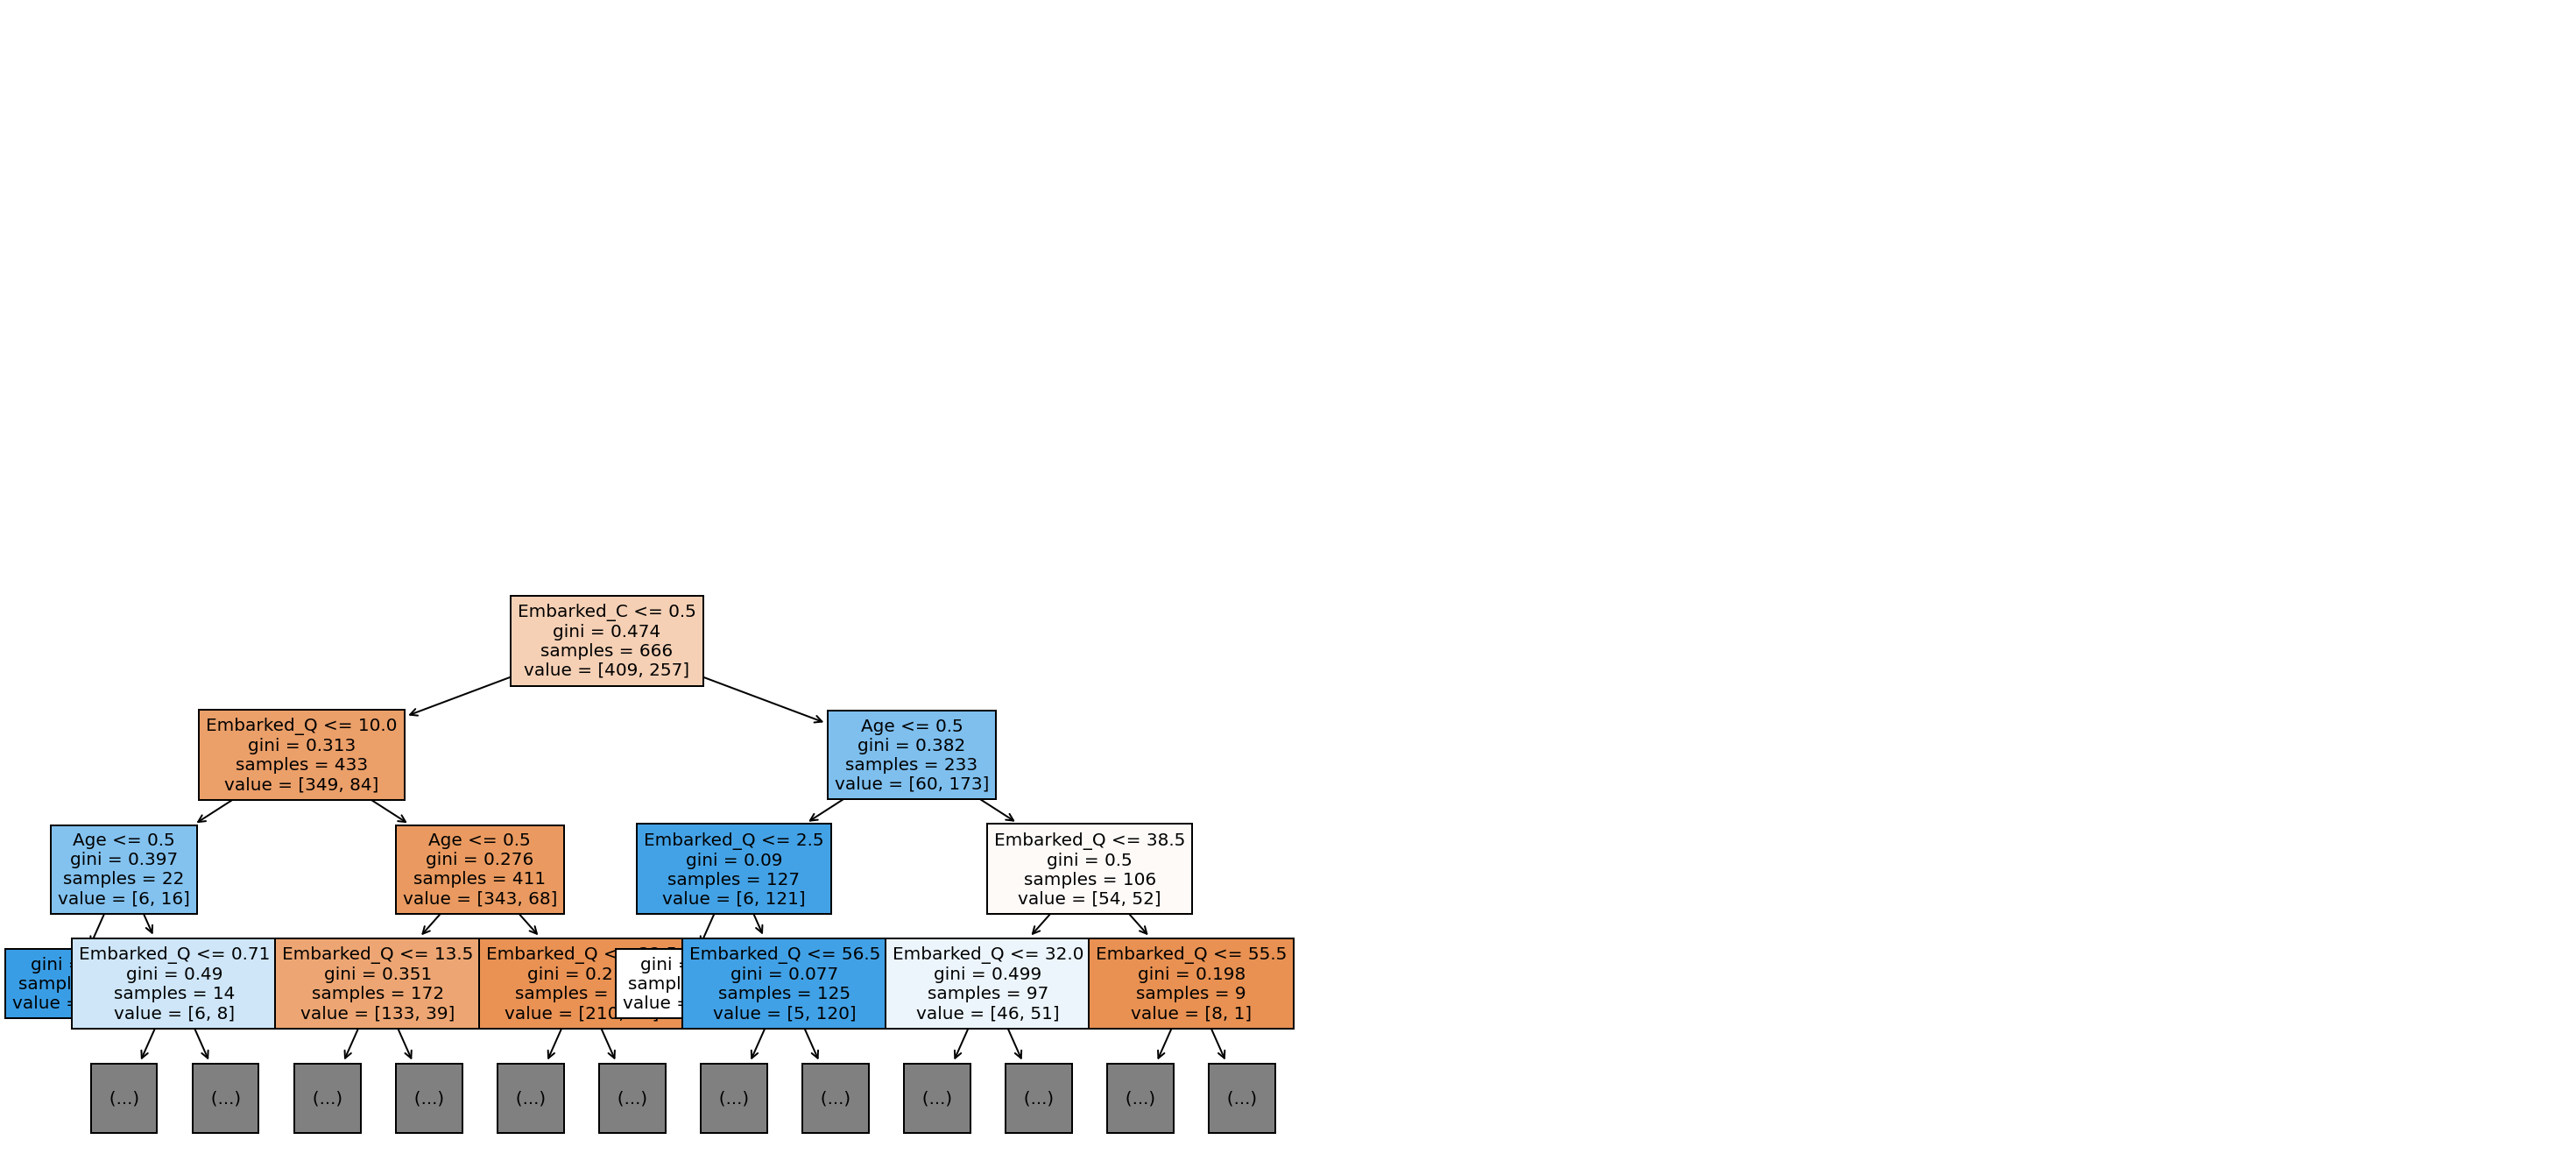

In [45]:
plt.figure(figsize=(26,12))

tree.plot_tree(dtc, fontsize=10,
              feature_names=X.columns,
              filled=True,
              impurity=True,
              max_depth=3)
plt.show()